In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as st
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags
from matplotlib import cm
from tqdm import tqdm
from scipy.stats import norm

log = np.log 
exp = np.exp 
sqrt = np.sqrt
ncdf = norm.cdf

**1-Bermudean Put using Longstaff Schwartz algorithm**

In [21]:


# Financial data 
S0 = 100 # Initial underlying price
r_input = 0.04 # Risk-free rate
sigma = 0.2 # Volatility
K = 100 # Strike
T = 1 # Maturity


# Numerical data 
MC = 100000# Number of paths
N=m = 10 # Number of time steps
t = np.linspace(0,T,m+1)[np.newaxis,:] # Corresponding time grid




In [22]:
# Longstaff-Schwartz regression basis 
basis1 = lambda x : 1
basis2 = lambda x : x
basis3 = lambda x : x**2

f = lambda x,alpha1,alpha2,alpha3 : alpha1*basis1(x) + alpha2*basis2(x) + alpha3*basis3(x) # Longstaff-Schwartz regression function

In [23]:
# d rows and N columns
def brownian_motion(T : float,N : int,d : int):
    if d == 1:
        return(np.insert(np.random.normal(scale = sqrt(T/N), size = N).cumsum(), 0, 0))
    elif d > 1:
        return(np.insert(np.random.normal(scale = sqrt(T/N), size = (d,N)).cumsum(axis = 1), 0, 0, axis = 1))

In [24]:

payoff_put = lambda x,K : (K-x)*(K-x >=0)
BS_process = lambda x0,r,sigma,t,W : x0*np.exp( (r- (sigma**2)/2)*t + sigma*W ) 
D = lambda X , t , r=r_input : X*exp(-r*t) # Discounting X from time 0 to time t

In [25]:
W = brownian_motion(T,m,MC)
S = BS_process(S0,r_input,sigma,t,W) 

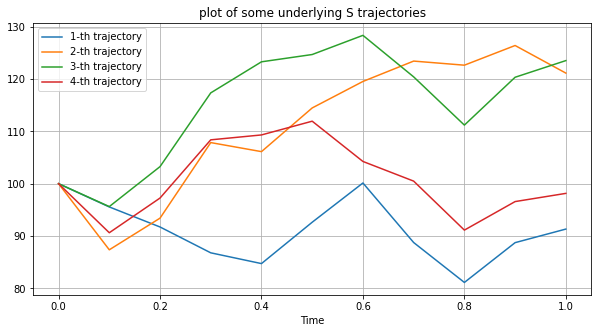

In [26]:
plt.subplots(figsize=(10,5))

for i in range(4):
    plt.plot(t[0],S[i], label = "{}-th trajectory".format(i+1))

plt.xlabel("Time") ; plt.title("plot of some underlying S trajectories")
plt.grid() ; plt.legend()
plt.show()

In [27]:
def LongStaff(S0 = S0, r = r_input, sigma = sigma, K = K, T = T, payoff = payoff_put, f = f, m = m, MC = MC):
    t = np.linspace(0,T,m+1)
    #m = len(t[0])
    D = np.exp(-r*(T/m))
    W = brownian_motion(T,m,MC)
    S = BS_process(S0,r,sigma,t,W) #St[i] gives the i-th trajectory therefore St[i,k] = S_{t_k}^{i}
    
    V = np.zeros(S.shape)
    V[:,-1] = payoff(S[:,-1],K) #the terminal value can only be the payoff of the option
    alphas = []
    for i in tqdm(range(m-1,0,-1)): # loop backward in time
        alpha, _ = curve_fit(f,xdata = S[:,i] ,ydata = V[:,i+1]) # y_{data} = f(x_{data}) + \varepsilon
        alphas.append(alpha)

        for j in range(MC-1,-1,-1): #loop in sample paths
            if (payoff(S[j,i],K) >= D*f(S[j,i],alpha[0],alpha[1],alpha[2])) :
                V[j,i] = payoff(S[j,i],K)
            else:
                V[j,i] = D*V[j,i+1] 
    V0 = max(payoff(S0,K), D*V[:,1].mean())
    return V0, alphas[::-1] 

In [28]:
V0_arr = np.zeros(10)
for i in tqdm(range(len(V0_arr))):
    V0_arr[i], alphas = LongStaff(S0=S0, K =K,r = r_input, T = T, sigma = sigma, payoff = payoff_put, m = m, MC = MC)
        
price = V0_arr.mean()
std = np.std(V0_arr)
IC = [price-1.96*std/sqrt(MC),price+1.96*std/sqrt(MC)]
print("Longstaff | The value of the option is : {} with IC = {}".format(price,IC))






100%|██████████| 10/10 [01:09<00:00,  6.91s/it]

Longstaff | The value of the option is : 6.198722865917712 with IC = [6.198535879193352, 6.198909852642072]


**2- Comparison with the Binomial Model **

In [30]:
class CRROption:
    def __init__(self, S0,r,sigma,T,framework="CRR"):
        self.S0 = S0
        self.T = T
        self.r=r
        self.dt = T/N
        self.sigma = sigma
        self.u =np.exp(self.sigma*np.sqrt(self.dt))
        self.d = 1.0/(self.u)
        self.p = (np.exp(self.r * self.dt) - self.d)/(self.u - self.d)
        if framework=="RB":
          self.p = 0.5
          self.u = np.exp(self.r-0.5*(pow(self.sigma,2))*self.dt+self.sigma*np.sqrt(self.dt))
          self.u = np.exp(self.r-0.5*(pow(self.sigma,2))*self.dt-self.sigma*np.sqrt(self.dt))

        
    def build_tree(self): 
        tree = np.zeros((N, N))
        for i in range(N):
            for j in range(i+1):
                tree[j, i] = self.S0 * (self.d**j) * (self.u**(i-j))          
        return tree

    def vanilla_option(self,K,payoff,T,method="european"):
      #return price of a path independant option using backward methodology in a CRR tree
      #parameters : 
      #:payoff : a function to define outside the class taking the strike as parameters expected to return terminal Payoff
      #:framework : Optional ,  Using CRR recommendation  RB model , both fits first two moment of Black_scholes model when Grid is sufficiently small
      #:K strike of the Option
      self.dt=T/N
      tree = self.build_tree()
      Prices = payoff(tree[:,-1],K)
      
      for i in range(N-1, 0,-1):
          Prices=((1-self.p)*Prices[1:] + (self.p)*Prices[:-1])*np.exp(-self.r*self.dt)
          if method=="american":
            Prices = np.maximum(Prices,payoff(tree[:i,i-1],K))  #Snell envelope at every step 
            
      return Prices[0]

    def plot_tree(self):
        tree = self.build_tree()
        fig, ax = plt.subplots()
        for i in range(N):
            for j in range(i+1):
                ax.plot([i, i+1], [-j, -(j+1)], 'b')
                ax.plot([i, i+1], [-j, -j], 'b')
                ax.plot(i, -j, 'ro')
                ax.text(i, -j-0.3, str(round(tree[j,i], 2)), ha='center', va='center')
        
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Values')
        ax.set_title('CRR Binomial Tree')
        plt.axis('off')
        plt.show()
    


model = CRROption(S0,r_input,sigma,T)

print(model.build_tree())

def put(SO,K):
  return np.maximum(K-SO,0)

#Plot and price Option using followings methods


print(f"European/American Call price  : {model.vanilla_option(110,put,1)} and {model.vanilla_option(110,put,1, method='american')}")


#to end => I was not able to imagine a structure of algorithm (in time delays) able to mimic LS algoritmh on a CRR dynamique in order to provide Bermudean put options , However we can see that Amercican options seems to be twice the price of a Bermudean option (wich is arbritrage free)

[[100.         106.52883921 113.48393583 120.89311953 128.78603692
  137.1942702  146.1514635  155.69345756 165.85843306 176.68706347]
 [  0.          93.87129414 100.         106.52883921 113.48393583
  120.89311953 128.78603692 137.1942702  146.1514635  155.69345756]
 [  0.           0.          88.11819864  93.87129414 100.
  106.52883921 113.48393583 120.89311953 128.78603692 137.1942702 ]
 [  0.           0.           0.          82.71769344  88.11819864
   93.87129414 100.         106.52883921 113.48393583 120.89311953]
 [  0.           0.           0.           0.          77.64816931
   82.71769344  88.11819864  93.87129414 100.         106.52883921]
 [  0.           0.           0.           0.           0.
   72.88934141  77.64816931  82.71769344  88.11819864  93.87129414]
 [  0.           0.           0.           0.           0.
    0.          68.42216807  72.88934141  77.64816931  82.71769344]
 [  0.           0.           0.           0.           0.
    0.           0. 